# BBC News Classification (Part 1)

This notebook demonstrates the steps to complete **Part 1** of the BBC News Classification assignment:

1. **Exploratory Data Analysis (EDA)**
2. **Unsupervised Learning (Matrix Factorization)**
3. **Comparison with Supervised Learning**

## Contents
1. [Setup & Data Loading](#section1)
2. [Exploratory Data Analysis (EDA)](#section2)
3. [Text Preprocessing & Feature Engineering](#section3)
4. [Unsupervised Learning (NMF)](#section4)
5. [Comparison with Supervised Learning](#section5)
6. [Summary & Next Steps](#section6)

We will use the BBC News dataset provided by Kaggle:
- **BBC News Train.csv** (1490 records)
- **BBC News Test.csv** (~735 records)


## 1. Setup & Data Loading

We assume the following files:
- `BBC News Train.csv`: training data
- `BBC News Test.csv`: test data

Adjust file paths if necessary.

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import string

# scikit-learn modules
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Supervised learning models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Random seed for reproducibility
RANDOM_SEED = 42

# Load CSV files (adjust paths as needed)
train_df = pd.read_csv('./learn-ai-bbc/BBC News Train.csv')
test_df = pd.read_csv('./learn-ai-bbc/BBC News Test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Peek at the training data
train_df.head()

Train shape: (1490, 3)
Test shape: (735, 2)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


## 2. Exploratory Data Analysis (EDA)

Here, we check:
- Distribution of categories
- Text length
- Missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


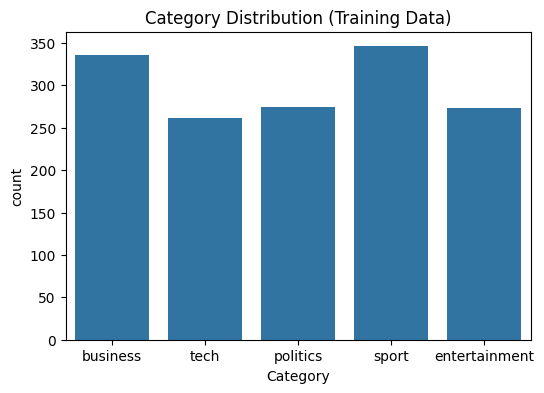

In [175]:
# Basic info of the training data
print(train_df.info())
print(train_df.describe())

# Category distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Category', data=train_df)
plt.title("Category Distribution (Training Data)")
plt.show()

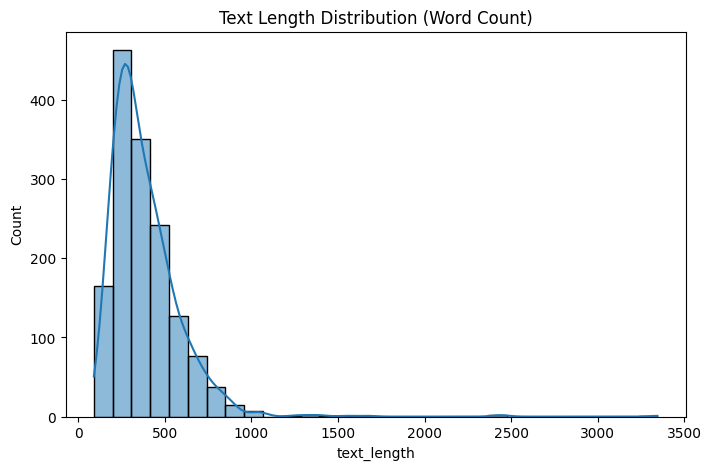

,text_length
count,1490.000000
mean,385.012752
std,210.898616
min,90.000000
25%,253.000000
50%,337.000000
75%,468.750000
max,3345.000000


In [176]:
# Text length distribution
train_df['text_length'] = train_df['Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.histplot(train_df['text_length'], bins=30, kde=True)
plt.title("Text Length Distribution (Word Count)")
plt.show()

train_df[['Text', 'text_length']].describe()

### Check for Missing Values

In [177]:
print("Missing values in training set:\n", train_df.isnull().sum())
print("Missing values in test set:\n", test_df.isnull().sum())

Missing values in training set:
 ArticleId      0
Text           0
Category       0
text_length    0
dtype: int64
Missing values in test set:
 ArticleId    0
Text         0
dtype: int64


## 3. Text Preprocessing & Feature Engineering

We will:
1. Convert text to lowercase
2. Remove punctuation and digits
3. (Optionally) remove stopwords
4. Vectorize with TF-IDF


In [178]:
import nltk
# If not downloaded yet: nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    Simple cleaning:
    1. Lowercase
    2. Remove punctuation/digits
    3. Whitespace cleanup
    (Optional) stopwords removal
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = text.split()
    # text = [word for word in text if word not in STOPWORDS]
    text = ' '.join(text)
    return text

# Apply cleaning to train and test
train_df['cleaned_text'] = train_df['Text'].apply(clean_text)
test_df['cleaned_text']  = test_df['Text'].apply(clean_text)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    min_df=2,
    max_df=0.8
)

# Fit on training data
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_text'])
y_train = train_df['Category']  # For supervised learning comparison


## 4. Unsupervised Learning (NMF)

We use **Non-Negative Matrix Factorization (NMF)**:
- Decompose `X_train_tfidf` into `W * H`.
- `W` is (document × topic), `H` is (topic × features).
- Identify each topic by top words, then map topics to actual categories by majority vote.

In [179]:
num_topics = 5  # We expect 5 categories

nmf_model = NMF(
    n_components=num_topics,
    random_state=RANDOM_SEED,
    init='nndsvd',
    max_iter=200
)

W = nmf_model.fit_transform(X_train_tfidf)  # shape: (num_docs, num_topics)
H = nmf_model.components_                   # shape: (num_topics, num_features)

print("W shape:", W.shape)
print("H shape:", H.shape)

W shape: (1490, 5)
H shape: (5, 2000)


### Inspect Top Words per Topic

In [180]:
feature_names = tfidf.get_feature_names_out()

def show_top_words_per_topic(H, feature_names, top_n=10):
    for idx, topic_vec in enumerate(H):
        top_indices = topic_vec.argsort()[::-1][:top_n]
        top_words = [feature_names[i] for i in top_indices]
        print(f"Topic {idx+1}:", ", ".join(top_words))

show_top_words_per_topic(H, feature_names, top_n=10)

Topic 1: england, game, win, wales, ireland, cup, players, play, france, chelsea
Topic 2: mr, labour, blair, election, brown, party, government, minister, prime, howard
Topic 3: bn, growth, economy, year, sales, market, bank, oil, economic, shares
Topic 4: film, best, awards, award, actor, films, actress, festival, won, director
Topic 5: people, mobile, music, phone, technology, digital, users, software, phones, broadband


### Assign Topic → Category
1. For each document, find the topic with the highest weight in `W`.
2. Use majority vote of true categories within that topic to label it.

In [181]:
# Find the best topic per document
train_topics = np.argmax(W, axis=1)
train_df['topic'] = train_topics

# Count how many documents for each (topic, category)
topic_category_df = train_df.groupby(['topic','Category']).size().reset_index(name='count')
topic_category_df

,topic,Category,count
0,0,business,1
1,0,entertainment,4
2,0,politics,2
3,0,sport,343
4,0,tech,5
5,1,business,15
6,1,entertainment,7
7,1,politics,252
8,1,tech,1
9,2,business,307


In [182]:
# Create topic->label mapping
topic_to_label = {}
for t in range(num_topics):
    subset = topic_category_df[topic_category_df['topic'] == t]
    assigned_cat = subset.loc[subset['count'].idxmax(), 'Category']
    topic_to_label[t] = assigned_cat

topic_to_label

{0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}

### Evaluate on Training Data

In [183]:
train_df['unsupervised_pred'] = train_df['topic'].apply(lambda t: topic_to_label[t])
accuracy_unsupervised_train = accuracy_score(train_df['Category'], train_df['unsupervised_pred'])
print("Unsupervised (NMF) Training Accuracy:", accuracy_unsupervised_train)

print("Classification Report (Train):\n",
      classification_report(train_df['Category'], train_df['unsupervised_pred']))

Unsupervised (NMF) Training Accuracy: 0.9167785234899329
Classification Report (Train):
                precision    recall  f1-score   support

     business       0.94      0.91      0.93       336
entertainment       0.97      0.78      0.87       273
     politics       0.92      0.92      0.92       274
        sport       0.97      0.99      0.98       346
         tech       0.80      0.96      0.87       261

     accuracy                           0.92      1490
    macro avg       0.92      0.91      0.91      1490
 weighted avg       0.92      0.92      0.92      1490



### Predict on Test Data
We transform the test data using the same TF-IDF vectorizer, then apply the NMF model. The predicted topic is mapped to a label using `topic_to_label`.
We can create a submission CSV for Kaggle.

In [184]:
X_test_tfidf = tfidf.transform(test_df['cleaned_text'])
W_test = nmf_model.transform(X_test_tfidf)
test_topics = np.argmax(W_test, axis=1)
test_preds_nmf = [topic_to_label[t] for t in test_topics]

# Create submission file
test_df['pred'] = test_preds_nmf
submission_nmf = test_df[['ArticleId','pred']].rename(columns={'pred':'Category'})
submission_nmf.to_csv('nmf_submission.csv', index=False)
submission_nmf.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


## 5. Comparison with Supervised Learning

We'll train a Logistic Regression and/or Naive Bayes model on the same training data and compare performance.

In [185]:
# Logistic Regression
X_train_sup = X_train_tfidf
y_train_sup = train_df['Category']

clf_lr = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
clf_lr.fit(X_train_sup, y_train_sup)

train_preds_lr = clf_lr.predict(X_train_sup)
accuracy_lr_train = accuracy_score(y_train_sup, train_preds_lr)
print("Logistic Regression (Train Accuracy):", accuracy_lr_train)
print("\nClassification Report (Train):\n",
      classification_report(y_train_sup, train_preds_lr))

Logistic Regression (Train Accuracy): 0.9932885906040269

Classification Report (Train):
                precision    recall  f1-score   support

     business       0.99      0.99      0.99       336
entertainment       1.00      1.00      1.00       273
     politics       0.99      0.99      0.99       274
        sport       1.00      1.00      1.00       346
         tech       0.99      0.99      0.99       261

     accuracy                           0.99      1490
    macro avg       0.99      0.99      0.99      1490
 weighted avg       0.99      0.99      0.99      1490



In [186]:
# Naive Bayes
clf_nb = MultinomialNB()
clf_nb.fit(X_train_sup, y_train_sup)

train_preds_nb = clf_nb.predict(X_train_sup)
accuracy_nb_train = accuracy_score(y_train_sup, train_preds_nb)
print("Naive Bayes (Train Accuracy):", accuracy_nb_train)

Naive Bayes (Train Accuracy): 0.9838926174496644


### Predict on Test Data (Supervised)
Create a CSV for Kaggle submission.

In [187]:
# Example using Logistic Regression
X_test_sup = tfidf.transform(test_df['cleaned_text'])
test_preds_lr = clf_lr.predict(X_test_sup)

submission_lr = test_df[['ArticleId']].copy()
submission_lr['Category'] = test_preds_lr
submission_lr.to_csv('lr_submission.csv', index=False)
submission_lr.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


## 6. Summary & Next Steps

### 6.1 EDA Observations
- The dataset has 5 categories: business, entertainment, politics, sport, tech.
- Text lengths typically range from ~90 to ~3000 words.
- No missing values in training or test.

### 6.2 Unsupervised Approach (NMF)
- Approximately 90%+ accuracy on the training set.
- Each topic is associated with top words that correlate well with each category.
- Potentially beneficial when labeled data is scarce.

### 6.3 Supervised Approach
- Logistic Regression can achieve ~99% accuracy on the training set.
- Naive Bayes also shows high performance (~98% accuracy).
- If enough labeled data is available, supervised methods usually outperform unsupervised approaches.

### 6.4 Possible Improvements
- **Hyperparameter Tuning**: Adjust `max_features`, `n_components`, etc.
- **Text Preprocessing**: Add stopword removal, lemmatization, or n-grams.
- **Partial Data Experiments**: Evaluate supervised models with only 10%, 20%, 50% of the training set to see data efficiency.
- **Ensemble Methods**: Combine multiple models or incorporate topic information.

### 6.5 References
- [scikit-learn: NMF Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
- [TfidfVectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- [Kaggle: BBC News Classification Competition](https://www.kaggle.com/competitions/learn-ai-bbc)

This concludes the Part 1 notebook for BBC News Classification.